<a href="https://colab.research.google.com/github/emundusov/compproject/blob/master/CompProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
tf_repo_url = 'https://github.com/tensorflow/models'

In [2]:
import os

%cd /content

repo_dir_path = os.path.abspath(os.path.join('.', os.path.basename(tf_repo_url)))

!git clone {tf_repo_url}
%cd {repo_dir_path}
!git pull

/content
Cloning into 'models'...
remote: Enumerating objects: 25, done.
remote: Counting objects: 100% (25/25), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 31137 (delta 3), reused 11 (delta 1), pack-reused 31112
Receiving objects: 100% (31137/31137), 510.68 MiB | 31.80 MiB/s, done.
Resolving deltas: 100% (19616/19616), done.
Checking out files: 100% (3057/3057), done.
/content/models
Already up to date.


In [3]:
!apt-get install -qq protobuf-compiler python-pil python-lxml python-tk

!pip install -q Cython contextlib2 pillow lxml matplotlib

!pip install -q pycocotools

%cd /content/models/research
!protoc object_detection/protos/*.proto --python_out=.

import os
os.environ['PYTHONPATH'] += ':/content/models/research/:/content/models/research/slim/'

!python object_detection/builders/model_builder_test.py

Selecting previously unselected package python-bs4.
(Reading database ... 131183 files and directories currently installed.)
Preparing to unpack .../0-python-bs4_4.6.0-1_all.deb ...
Unpacking python-bs4 (4.6.0-1) ...
Selecting previously unselected package python-pkg-resources.
Preparing to unpack .../1-python-pkg-resources_39.0.1-2_all.deb ...
Unpacking python-pkg-resources (39.0.1-2) ...
Selecting previously unselected package python-chardet.
Preparing to unpack .../2-python-chardet_3.0.4-1_all.deb ...
Unpacking python-chardet (3.0.4-1) ...
Selecting previously unselected package python-six.
Preparing to unpack .../3-python-six_1.11.0-2_all.deb ...
Unpacking python-six (1.11.0-2) ...
Selecting previously unselected package python-webencodings.
Preparing to unpack .../4-python-webencodings_0.5-2_all.deb ...
Unpacking python-webencodings (0.5-2) ...
Selecting previously unselected package python-html5lib.
Preparing to unpack .../5-python-html5lib_0.999999999-1_all.deb ...
Unpacking pyt

In [4]:
%cd /content/models/research
!python3 setup.py install

/content/models/research
running install
running bdist_egg
running egg_info
creating object_detection.egg-info
writing object_detection.egg-info/PKG-INFO
writing dependency_links to object_detection.egg-info/dependency_links.txt
writing requirements to object_detection.egg-info/requires.txt
writing top-level names to object_detection.egg-info/top_level.txt
writing manifest file 'object_detection.egg-info/SOURCES.txt'
writing manifest file 'object_detection.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build
creating build/lib
creating build/lib/object_detection
copying object_detection/exporter.py -> build/lib/object_detection
copying object_detection/inputs.py -> build/lib/object_detection
copying object_detection/export_tflite_ssd_graph_lib_test.py -> build/lib/object_detection
copying object_detection/inputs_test.py -> build/lib/object_detection
copying object_detection/model_tpu_main.py -> build/lib/objec

In [0]:
cp_repo_url = 'https://github.com/emundusov/compproject'


In [6]:
import os

%cd /content

repo_dir_path2 = os.path.abspath(os.path.join('.', os.path.basename(tf_repo_url)))

!git clone {cp_repo_url}
%cd {repo_dir_path2}
!git pull

/content
Cloning into 'compproject'...
remote: Enumerating objects: 107, done.
remote: Counting objects: 100% (107/107), done.
remote: Compressing objects: 100% (59/59), done.
remote: Total 1358 (delta 49), reused 102 (delta 48), pack-reused 1251
Receiving objects: 100% (1358/1358), 87.74 MiB | 27.77 MiB/s, done.
Resolving deltas: 100% (731/731), done.
/content/models
Already up to date.


In [0]:
import os
import shutil

shutil.rmtree('/content/compproject/images/converted_annotation_in_txt')


In [12]:
import cv2
import numpy as np
import os
import xml.etree.ElementTree as ET

out_path = "/content/compproject/images/bb_box.txt"
data_path = "/content/compproject/images/train"
img_path = "/content/compproject/images/train"
xml_path = "/content/compproject/images/train"




def pca_color_augmentation(image):
    assert image.ndim == 3 and image.shape[2] == 3
    assert image.dtype == np.uint8
    img = image.reshape(-1, 3).astype(np.float32)
    sf = np.sqrt(3.0/np.sum(np.var(img, axis=0)))
    img = (img - np.mean(img, axis=0))*sf 
    cov = np.cov(img, rowvar=False) # calculate the covariance matrix
    value, p = np.linalg.eig(cov) # calculation of eigen vector and eigen value 
    rand = np.random.randn(3)*0.08
    delta = np.dot(p, rand*value)
    delta = (delta*255.0).astype(np.int32)[np.newaxis, np.newaxis, :]
    img_out = np.clip(image+delta, 0, 255).astype(np.uint8)
    return img_out


xml_paths = [os.path.join(xml_path, s) for s in os.listdir(xml_path) if s.endswith('.xml')]
#print(xml_paths)

pwd_lines = []
for xml_file in xml_paths:
    et = ET.parse(xml_file)
    element = et.getroot()
    element_objs = element.findall('object') 
    element_filename = element.find('filename').text
    base_filename = os.path.join(data_path, element_filename)
    print(base_filename)                               
    img = cv2.imread(base_filename)
    rows, cols = img.shape[:2] 

    img_split = element_filename.strip().split('.jpg')
        
    for element_obj in element_objs:
        class_name = element_obj.find('name').text # return name tag ie class of disease from xml file

        obj_bbox = element_obj.find('bndbox')
        #print(obj_bbox)
        x1 = int(round(float(obj_bbox.find('xmin').text)))
        y1 = int(round(float(obj_bbox.find('ymin').text)))
        x2 = int(round(float(obj_bbox.find('xmax').text)))
        y2 = int(round(float(obj_bbox.find('ymax').text)))
# if you specify range(1) total number of augmented data is 6 for one image
# 6 types of augmentation means pca, horizontal and vertical flip, 3 rotation
# if you specify range(2) total number of augmented data is 12 for one image
        for color in range(1):
            img_color = pca_color_augmentation(img)
            color_name = img_split[0]+ '-color' + str(color)
            color_jpg = color_name + '.jpg'
            new_path = os.path.join(img_path, color_jpg) # join with augmented image path
            lines = [color_jpg, ',', str(x1), ',', str(y1), ',', str(x2), ',', str(y2), ',', class_name, '\n']
            pwd_lines.append(lines)
            if not os.path.isfile(new_path):
                cv2.imwrite(new_path, img_color)
            
            # for horizontal and vertical flip
            f_points = [0, 1]
            for f in f_points:
                f_img = cv2.flip(img_color, f)
                h,w = img_color.shape[:2]
                
                if f == 1:
                    f_x1 = w-x2
                    f_y1 = y1
                    f_x2 = w-x1
                    f_y2 = y2
                    f_str = 'f1'
                elif f == 0:
                    f_x1 = x1
                    f_y1 = h-y2
                    f_x2 = x2
                    f_y2 = h-y1
                    f_str = 'f0'
                
                new_name = color_name + '-' + f_str + '.jpg'
                new_path = os.path.join(img_path, new_name)
                
                lines = [new_name, ',', str(f_x1), ',', str(f_y1), ',', str(f_x2), ',', str(f_y2), ',', class_name, '\n']
                pwd_lines.append(lines)
                if not os.path.isfile(new_path):
                    cv2.imwrite(new_path, f_img)
                    
            # for angle 90
            img_transpose = np.transpose(img_color, (1,0,2))
            img_90 = cv2.flip(img_transpose, 1)
            h,w = img_color.shape[:2]
            angle_x1 = h - y2
            angle_y1 = x1
            angle_x2 = h -y1
            angle_y2 = x2
            new_name = color_name + '-' + 'rotate_90' + '.jpg'
            new_path = os.path.join(img_path, new_name)
            lines = [new_name, ',', str(angle_x1), ',', str(angle_y1), ',', str(angle_x2), ',', str(angle_y2), ',', class_name, '\n']
            pwd_lines.append(lines)
            if not os.path.isfile(new_path):
                cv2.imwrite(new_path,img_90)
                
            #for angle 180
            img_180 = cv2.flip(img_color, -1)
            ang_x1 = w - x2
            ang_y1 = h - y2
            ang_x2 = w - x1
            ang_y2 = h - y1
            new_name_180 = color_name + '-' + 'rotate_180' + '.jpg'
            new_path_180 = os.path.join(img_path, new_name_180)
            lines_180 = [new_name_180, ',', str(ang_x1), ',', str(ang_y1), ',', str(ang_x2), ',', str(ang_y2), ',', class_name, '\n']
            pwd_lines.append(lines_180)
            if not os.path.isfile(new_path_180):
                cv2.imwrite(new_path_180,img_180)
                
            #for angle 270
            img_transpose_270 = np.transpose(img_color, (1,0,2))
            img_270 = cv2.flip(img_transpose_270, 0)
            an_x1 = y1
            an_y1 = w - x2
            an_x2 = y2
            an_y2 = w - x1
            new_name_270 = color_name + '-' + 'rotate_270' + '.jpg'
            new_path_270 = os.path.join(img_path, new_name_270)
            lines_270 = [new_name_270, ',', str(an_x1), ',', str(an_y1), ',', str(an_x2), ',', str(an_y2), ',', class_name, '\n']
            pwd_lines.append(lines_270)
            if not os.path.isfile(new_path_270):
                cv2.imwrite(new_path_270, img_270)
    
#print(pwd_lines)
if len(pwd_lines) > 0 :
    with open(out_path, 'w') as f:
        for line in pwd_lines:
            f.writelines(line)
            
print('End')

/content/compproject/images/train/palm_15.jpg
/content/compproject/images/train/peace_78.jpg
/content/compproject/images/train/ok_91.jpg
/content/compproject/images/train/ok_35.jpg
/content/compproject/images/train/palm_35.jpg
/content/compproject/images/train/peace_3.jpg
/content/compproject/images/train/peace_87.jpg
/content/compproject/images/train/ok_79.jpg
/content/compproject/images/train/ok_77.jpg
/content/compproject/images/train/peace_92.jpg
/content/compproject/images/train/ok_9.jpg
/content/compproject/images/train/palm_24.jpg
/content/compproject/images/train/palm_94.jpg
/content/compproject/images/train/ok_20.jpg
/content/compproject/images/train/ok_87.jpg
/content/compproject/images/train/palm_34.jpg
/content/compproject/images/train/ok_76.jpg
/content/compproject/images/train/ok_59.jpg
/content/compproject/images/train/ok_1.jpg
/content/compproject/images/train/peace_28.jpg
/content/compproject/images/train/palm_28.jpg
/content/compproject/images/train/palm_43.jpg
/conte

In [0]:
!mkdir /content/compproject/images/converted_annotation_in_txt

In [14]:
datapath = "/content/compproject/images/bb_box.txt"
savepath = "/content/compproject/images/converted_annotation_in_txt/"
filepath = "/content/compproject/images/file_name.txt"

def make_dataset(input_path):
    all_imgs = {}
    print("the input path is", input_path)
    with open(input_path,'r') as f:
        print('Parsing annotation files')
        for line in f:
            line_split = line.strip().split(',')
            (filename,x1,y1,x2,y2,class_name) = line_split
            if filename not in all_imgs:
                all_imgs[filename] = {}
                
                all_imgs[filename]['filepath'] = filename
                all_imgs[filename]['bboxes'] = []
                
            all_imgs[filename]['bboxes'].append({'class': class_name, 'x1': int(x1), 'x2': int(x2), 'y1': int(y1), 'y2': int(y2)})
            
        all_data = []
        
        for key in all_imgs:
            all_data.append(all_imgs[key])
            
        return all_data
            
dataset = make_dataset(datapath)

for i in range(len(dataset)):
    dataset_path = dataset[i]['filepath']
    dataset_name = dataset_path.split(',')[0]
    sep_dataset = dataset[i]['bboxes']
    
    with open(filepath, 'a') as fn:
        file_name = "{}\n".format(dataset_name)
        fn.write(file_name)
        
    with open(savepath + str(dataset_name)+ ".txt", 'w') as f:
        for j in range(len(sep_dataset)):
            save_dataset = sep_dataset[j]
            
            data = "{} {} {} {} {} \n".format(sep_dataset[j]['class'],sep_dataset[j]['x1'],sep_dataset[j]['y1'], sep_dataset[j]['x2'], sep_dataset[j]['y2'])
            
            f.write(data)

the input path is /content/compproject/images/bb_box.txt
Parsing annotation files


In [15]:
import os
import xml.etree.cElementTree as ET
from PIL import Image

ANNOTATIONS_DIR_PREFIX = "/content/compproject/images/converted_annotation_in_txt"

DESTINATION_DIR = "/content/compproject/images/train"

def create_root(file_prefix, width, height):
    root = ET.Element("annotations")
    ET.SubElement(root, "filename").text = "{}.jpg".format(file_prefix)
    ET.SubElement(root, "folder").text = "images"
    size = ET.SubElement(root, "size")
    ET.SubElement(size, "width").text = str(width)
    ET.SubElement(size, "height").text = str(height)
    ET.SubElement(size, "depth").text = "3"
    return root

def create_object_annotation(root, voc_labels):
    for voc_label in voc_labels:
        obj = ET.SubElement(root, "object")
        ET.SubElement(obj, "name").text = voc_label[0]
        ET.SubElement(obj, "pose").text = "Unspecified"
        ET.SubElement(obj, "truncated").text = str(0)
        ET.SubElement(obj, "difficult").text = str(0)
        bbox = ET.SubElement(obj, "bndbox")
        ET.SubElement(bbox, "xmin").text = str(voc_label[1])
        ET.SubElement(bbox, "ymin").text = str(voc_label[2])
        ET.SubElement(bbox, "xmax").text = str(voc_label[3])
        ET.SubElement(bbox, "ymax").text = str(voc_label[4])
    return root

def create_file(file_prefix, width, height, voc_labels):
    root = create_root(file_prefix, width, height)
    root = create_object_annotation(root, voc_labels)
    tree = ET.ElementTree(root)
    tree.write("/content/compproject/images/train/{}.xml".format(file_prefix))

def read_file(file_path):
    file_prefix = file_path.split(".jpg")[0]
    file_path_data = "/content/compproject/images/converted_annotation_in_txt/" + file_path
    print("the file path data", file_path_data)
    image_file_name = "{}.jpg".format(file_prefix)
    img = Image.open("{}/{}".format("/content/compproject/images/train", image_file_name))
    w, h = img.size
    with open(file_path_data, 'r') as file:
        lines = file.readlines()
        voc_labels = []
        for line in lines:
            voc = []
            line = line.strip()
            data = line.split()
            print(data[0],data[1],data[2],data[3],data[4])
            voc.append(data[0])
            voc.append(data[1])
            voc.append(data[2])
            voc.append(data[3])
            voc.append(data[4])
            voc_labels.append(voc)
            print(voc_labels)
        create_file(file_prefix, w, h, voc_labels)
    print("Processing complete for file: {}".format(file_path))

def start():
    if not os.path.exists(DESTINATION_DIR):
        os.makedirs(DESTINATION_DIR)
    for filename in os.listdir(ANNOTATIONS_DIR_PREFIX):
        print(filename)
        if filename.endswith('txt'):
            read_file(filename)
        else:
            print("Skipping file: {}".format(filename))


if __name__ == "__main__":
    start()

peace_54-color0.jpg.txt
the file path data /content/compproject/images/converted_annotation_in_txt/peace_54-color0.jpg.txt
peacesign 472 43 778 667
[['peacesign', '472', '43', '778', '667']]
Processing complete for file: peace_54-color0.jpg.txt
peace_23-color0.jpg.txt
the file path data /content/compproject/images/converted_annotation_in_txt/peace_23-color0.jpg.txt
peacesign 299 40 767 799
[['peacesign', '299', '40', '767', '799']]
Processing complete for file: peace_23-color0.jpg.txt
palm_42-color0-rotate_270.jpg.txt
the file path data /content/compproject/images/converted_annotation_in_txt/palm_42-color0-rotate_270.jpg.txt
palmhand 166 151 303 388
[['palmhand', '166', '151', '303', '388']]
Processing complete for file: palm_42-color0-rotate_270.jpg.txt
ok_80-color0-f1.jpg.txt
the file path data /content/compproject/images/converted_annotation_in_txt/ok_80-color0-f1.jpg.txt
oksign 165 156 438 589
[['oksign', '165', '156', '438', '589']]
Processing complete for file: ok_80-color0-f1.jp

In [0]:
MODELS_CONFIG = {
    'ssd_mobilenet_v2': {
        'model_name': 'ssd_mobilenet_v2_quantized_300x300_coco_2019_01_03'
    }
}
selected_model = 'ssd_mobilenet_v2'
MODEL = MODELS_CONFIG[selected_model]['model_name']

In [8]:
%cd /content/models/research

import os
import shutil
import glob
import urllib.request
import tarfile
MODEL_FILE = MODEL + '.tar.gz'
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'
DEST_DIR = '/content/models/research/pretrained_model'

if not (os.path.exists(MODEL_FILE)):
    urllib.request.urlretrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)

tar = tarfile.open(MODEL_FILE)
tar.extractall()
tar.close()

os.remove(MODEL_FILE)
if (os.path.exists(DEST_DIR)):
    shutil.rmtree(DEST_DIR)
os.rename(MODEL, DEST_DIR)

/content/models/research


In [28]:
%cd /content/compproject


/content/compproject


In [45]:
!python xml_to_csv.py

Successfully converted xml to csv.
Successfully converted xml to csv.
Successfully converted xml to csv.


In [11]:
!python3 generate_tfrecord.py --csv_input=data/train_labels.csv --output_path=data/train.record --image_dir=images/train



W1009 02:45:57.952476 139746153695104 module_wrapper.py:137] From generate_tfrecord.py:90: The name tf.python_io.TFRecordWriter is deprecated. Please use tf.io.TFRecordWriter instead.


W1009 02:45:58.087578 139746153695104 module_wrapper.py:137] From generate_tfrecord.py:49: The name tf.gfile.GFile is deprecated. Please use tf.io.gfile.GFile instead.

Successfully created the TFRecords: /content/compproject/data/train.record


In [12]:
!python3 generate_tfrecord.py --csv_input=data/test_labels.csv --output_path=data/test.record --image_dir=images/test



W1009 02:46:09.051358 139631189133184 module_wrapper.py:137] From generate_tfrecord.py:90: The name tf.python_io.TFRecordWriter is deprecated. Please use tf.io.TFRecordWriter instead.


W1009 02:46:09.081784 139631189133184 module_wrapper.py:137] From generate_tfrecord.py:49: The name tf.gfile.GFile is deprecated. Please use tf.io.gfile.GFile instead.

Successfully created the TFRecords: /content/compproject/data/test.record


In [46]:
!python3 generate_tfrecord.py --csv_input=data/valid_labels.csv --output_path=data/valid.record --image_dir=images/valid



W1010 04:18:13.757983 139959903520640 module_wrapper.py:139] From generate_tfrecord.py:90: The name tf.python_io.TFRecordWriter is deprecated. Please use tf.io.TFRecordWriter instead.


W1010 04:18:13.878118 139959903520640 module_wrapper.py:139] From generate_tfrecord.py:49: The name tf.gfile.GFile is deprecated. Please use tf.io.gfile.GFile instead.

Successfully created the TFRecords: /content/compproject/data/valid.record


In [13]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip -o ngrok-stable-linux-amd64.zip

--2019-10-09 02:46:20--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 52.86.84.98, 52.205.50.157, 3.227.43.216, ...
Connecting to bin.equinox.io (bin.equinox.io)|52.86.84.98|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13773305 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  13.13M  14.6MB/s    in 0.9s    

2019-10-09 02:46:21 (14.6 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [13773305/13773305]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   


In [0]:
model_dir = '/content/compproject/training'
LOG_DIR = model_dir
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)

In [0]:
get_ipython().system_raw('./ngrok http 6006 &')

In [16]:
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

https://7d327966.ngrok.io


In [17]:
!python /content/models/research/object_detection/legacy/train.py --logtostderr --train_dir=/content/compproject/training --pipeline_config_path=/content/compproject/training/ssd_mobilenet_v2.config

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.





Instructions for updating:
Use object_detection/model_main.py.
W1009 02:46:57.924104 140425799219072 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/absl/app.py:250: main (from __main__) is deprecated and will be removed in a future version.
Instructions for updating:
Use object_detection/model_main.py.

W1009 02:46:57.924417 140425799219072 module_wrapper.py:137] From /content/models/research/object_detection/legacy/train.py:90: The name tf.gfile.MakeDirs is deprecated. Please use tf.io.gfile.makedirs instead.

Instructions for updating:
Please switch to tf.train.create_global_step
W1009 02:46:57.931758 1404

In [0]:
import os

pb_fname = os.path.join(os.path.abspath('/content/compproject/training'), "frozen_inference_graph_300.pb")
assert os.path.isfile(pb_fname), '`{}` not exist'.format(pb_fname)

In [23]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once in a notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials


# Authenticate and create the PyDrive client.
# This only needs to be done once in a notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

fname = os.path.basename(pb_fname)
# Create & upload a text file.
uploaded = drive.CreateFile({'title': fname})
uploaded.SetContentFile(pb_fname)
uploaded.Upload()
print('Uploaded file with ID {}'.format(uploaded.get('id')))

Uploaded file with ID 1UscSJTN8SPZzV4gF8JGwcfoCqBC_lsG9


In [24]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [49]:
!python3 /content/models/research/object_detection/inference/infer_detections.py \
    --input_tfrecord_paths=/content/compproject/data/valid.record \
    --output_tfrecord_path=/content/compproject/detections.record \
    --inference_graph=/content/compproject/training/frozen_inference_graph_2100.pb



W1010 04:22:54.939427 139974849140608 module_wrapper.py:139] From /content/models/research/object_detection/inference/infer_detections.py:57: The name tf.logging.set_verbosity is deprecated. Please use tf.compat.v1.logging.set_verbosity instead.


W1010 04:22:54.939744 139974849140608 module_wrapper.py:139] From /content/models/research/object_detection/inference/infer_detections.py:57: The name tf.logging.INFO is deprecated. Please use tf.compat.v1.logging.INFO instead.


W1010 04:22:54.939942 139974849140608 module_wrapper.py:139] From /content/models/research/object_detection/inference/infer_detections.py:65: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.

2019-10-10 04:22:54.942297: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2019-10-10 04:22:54.962290: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there 

In [48]:
!python3 confusion_matrix.py --detections_record=detections.record --label_map=/content/compproject/training/labelmap.pbtxt --output_path=confusion_matrix_300.csv




W1010 04:19:05.557204 139977069356928 module_wrapper.py:139] From /content/models/research/object_detection/utils/label_map_util.py:137: The name tf.gfile.GFile is deprecated. Please use tf.io.gfile.GFile instead.

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`
W1010 04:19:05.559253 139977069356928 deprecation.py:323] From confusion_matrix.py:38: tf_record_iterator (from tensorflow.python.lib.io.tf_record) is deprecated and will be removed in a future version.
Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`
Processed 100 images
Processed 200 images
Processed 228 images

Confusion Matrix:
[[67.  0.  4.  5.]
 [29. 30.  5. 12.]
 [20.  1. 45. 10.]
 [ 8.  3.  7.  0.]] 

    category  ...  m_recall_@0.5IOU
0  peacesign  ...          0.881579
1   palmhand  ...          0.394737
2     oksign  ...          0.592105

[3 rows x 4 columns]


In [50]:
!python3 confusion_matrix.py --detections_record=detections.record --label_map=/content/compproject/training/labelmap.pbtxt --output_path=confusion_matrix_2100.csv




W1010 04:23:27.329237 140187422312320 module_wrapper.py:139] From /content/models/research/object_detection/utils/label_map_util.py:137: The name tf.gfile.GFile is deprecated. Please use tf.io.gfile.GFile instead.

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`
W1010 04:23:27.331402 140187422312320 deprecation.py:323] From confusion_matrix.py:38: tf_record_iterator (from tensorflow.python.lib.io.tf_record) is deprecated and will be removed in a future version.
Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`
Processed 100 images
Processed 200 images
Processed 228 images

Confusion Matrix:
[[74.  0.  0.  2.]
 [18. 48.  1.  9.]
 [13.  1. 56.  6.]
 [18. 11.  3.  0.]] 

    category  ...  m_recall_@0.5IOU
0  peacesign  ...          0.973684
1   palmhand  ...          0.631579
2     oksign  ...          0.736842

[3 rows x 4 columns]


In [0]:
import os
import shutil

shutil.rmtree('/content/compproject/training')

In [0]:
!mkdir /content/compproject/training

In [0]:
%cd /content/models/research
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from distutils.version import StrictVersion
from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")
from object_detection.utils import ops as utils_ops

if StrictVersion(tf.__version__) < StrictVersion('1.12.0'):
  raise ImportError('Please upgrade your TensorFlow installation to v1.12.*.')
  
%matplotlib inline

from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

output_directory = '/content/compproject/training'

/content/models/research


In [18]:
!python /content/models/research/object_detection/export_inference_graph.py --input_type image_tensor --pipeline_config_path=/content/compproject/training/ssd_mobilenet_v2.config --trained_checkpoint_prefix=/content/compproject/training/model.ckpt-1000 --output_directory /content/compproject/training

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.





W1009 04:15:39.429652 140646824134528 module_wrapper.py:137] From /content/models/research/object_detection/export_inference_graph.py:145: The name tf.gfile.GFile is deprecated. Please use tf.io.gfile.GFile instead.


W1009 04:15:39.482714 140646824134528 module_wrapper.py:137] From /content/models/research/object_detection/core/preprocessor.py:2660: The name tf.image.resize_images is deprecated. Please use tf.image.resize instead.

Instructions for updating:
Please use `layer.__call__` method instead.
W1009 04:15:39.525027 140646824134528 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow_core/contri

In [0]:
import os

pb_fname = os.path.join(os.path.abspath(output_directory), "frozen_inference_graph.pb")
assert os.path.isfile(pb_fname), '`{}` not exist'.format(pb_fname)

# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_FROZEN_GRAPH ='/content/compproject/training/frozen_inference_graph.pb'

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = '/content/compproject/training/object-detection.pbtxt'

In [0]:
# For the sake of simplicity we will use only 2 images:
# image1.jpg
# image2.jpg
# If you want to test the code with your images, just add path to the images to the TEST_IMAGE_PATHS.
PATH_TO_TEST_IMAGES_DIR = '/content/compproject/images/valid'
TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, 'image{}.jpg'.format(i)) for i in range(1, 3) ]

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)

import os
import glob

# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_CKPT = pb_fname

assert os.path.isfile(pb_fname)
assert os.path.isfile(PATH_TO_LABELS)
TEST_IMAGE_PATHS = glob.glob(os.path.join(PATH_TO_TEST_IMAGES_DIR, "*.*"))
assert len(TEST_IMAGE_PATHS) > 0, 'No image found in `{}`.'.format(PATH_TO_TEST_IMAGES_DIR)
print(TEST_IMAGE_PATHS)

num_classes = 3

['/content/compproject/images/valid/image2.jpg', '/content/compproject/images/valid/image1.jpg']


In [0]:
def get_num_classes(pbtxt_fname):
    from object_detection.utils import label_map_util
    label_map = label_map_util.load_labelmap(pbtxt_fname)
    categories = label_map_util.convert_label_map_to_categories(
        label_map, max_num_classes=90, use_display_name=True)
    category_index = label_map_util.create_category_index(categories)
    return len(category_index.keys())

/content/models/research/object_detection



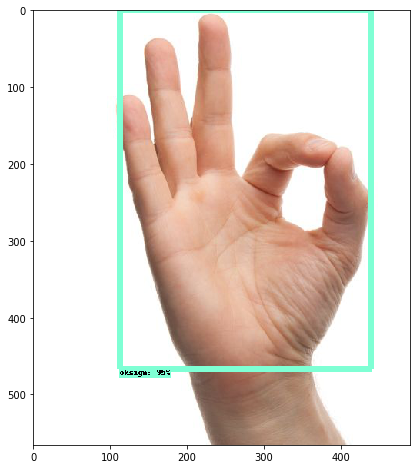

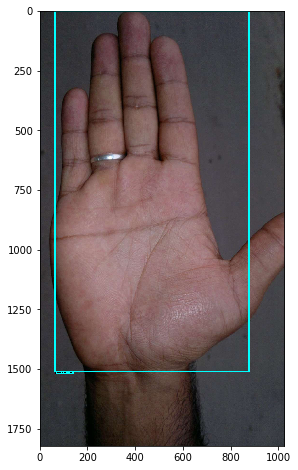

In [0]:
%cd /content/models/research/object_detection

import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")
from object_detection.utils import ops as utils_ops


# This is needed to display the images.
%matplotlib inline


from object_detection.utils import label_map_util

from object_detection.utils import visualization_utils as vis_util


detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')


label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(
    label_map, max_num_classes=num_classes, use_display_name=True)
category_index = label_map_util.create_category_index(categories)


def load_image_into_numpy_array(image):
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape(
        (im_height, im_width, 3)).astype(np.uint8)

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)


def run_inference_for_single_image(image, graph):
    with graph.as_default():
        with tf.Session() as sess:
            # Get handles to input and output tensors
            ops = tf.get_default_graph().get_operations()
            all_tensor_names = {
                output.name for op in ops for output in op.outputs}
            tensor_dict = {}
            for key in [
                'num_detections', 'detection_boxes', 'detection_scores',
                'detection_classes', 'detection_masks'
            ]:
                tensor_name = key + ':0'
                if tensor_name in all_tensor_names:
                    tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
                        tensor_name)
            if 'detection_masks' in tensor_dict:
                # The following processing is only for single image
                detection_boxes = tf.squeeze(
                    tensor_dict['detection_boxes'], [0])
                detection_masks = tf.squeeze(
                    tensor_dict['detection_masks'], [0])
                # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
                real_num_detection = tf.cast(
                    tensor_dict['num_detections'][0], tf.int32)
                detection_boxes = tf.slice(detection_boxes, [0, 0], [
                                           real_num_detection, -1])
                detection_masks = tf.slice(detection_masks, [0, 0, 0], [
                                           real_num_detection, -1, -1])
                detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
                    detection_masks, detection_boxes, image.shape[0], image.shape[1])
                detection_masks_reframed = tf.cast(
                    tf.greater(detection_masks_reframed, 0.5), tf.uint8)
                # Follow the convention by adding back the batch dimension
                tensor_dict['detection_masks'] = tf.expand_dims(
                    detection_masks_reframed, 0)
            image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

            # Run inference
            output_dict = sess.run(tensor_dict,
                                   feed_dict={image_tensor: np.expand_dims(image, 0)})

            # all outputs are float32 numpy arrays, so convert types as appropriate
            output_dict['num_detections'] = int(
                output_dict['num_detections'][0])
            output_dict['detection_classes'] = output_dict[
                'detection_classes'][0].astype(np.uint8)
            output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
            output_dict['detection_scores'] = output_dict['detection_scores'][0]
            if 'detection_masks' in output_dict:
                output_dict['detection_masks'] = output_dict['detection_masks'][0]
    return output_dict


for image_path in TEST_IMAGE_PATHS:
    image = Image.open(image_path)
    # the array based representation of the image will be used later in order to prepare the
    # result image with boxes and labels on it.
    image_np = load_image_into_numpy_array(image)
    # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
    image_np_expanded = np.expand_dims(image_np, axis=0)
    # Actual detection.
    output_dict = run_inference_for_single_image(image_np, detection_graph)
    # Visualization of the results of a detection.
    vis_util.visualize_boxes_and_labels_on_image_array(
        image_np,
        output_dict['detection_boxes'],
        output_dict['detection_classes'],
        output_dict['detection_scores'],
        category_index,
        instance_masks=output_dict.get('detection_masks'),
        use_normalized_coordinates=True,
        line_thickness=8)
    plt.figure(figsize=IMAGE_SIZE)
    plt.imshow(image_np)

In [25]:
%cd /content/models/research/object_detection


/content/models/research/object_detection


In [26]:
!python export_tflite_ssd_graph.py --pipeline_config_path=/content/compproject/training/ssd_mobilenet_v2.config --trained_checkpoint_prefix=/content/compproject/training/model.ckpt-1000 --output_directory=/content/compproject/litemodel --add_postprocessing_op=true

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.





W1009 04:30:23.210998 140166865774464 module_wrapper.py:137] From export_tflite_ssd_graph.py:133: The name tf.gfile.GFile is deprecated. Please use tf.io.gfile.GFile instead.

Instructions for updating:
Please use `layer.__call__` method instead.
W1009 04:30:23.223653 140166865774464 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow_core/contrib/layers/python/layers/layers.py:1057: Layer.apply (from tensorflow.python.keras.engine.base_layer) is deprecated and will be removed in a future version.
Instructions for updating:
Please use `layer.__call__` method instead.

W1009 04:30:26.027598 140166865774

In [27]:
!tflite_convert \
--graph_def_file=/content/compproject/litemodel/tflite_graph.pb \
--output_file=/content/compproject/litemodel/detect.tflite \
--output_format=TFLITE \
--input_shapes=1,300,300,3 \
--input_arrays=normalized_input_image_tensor \
--output_arrays='TFLite_Detection_PostProcess','TFLite_Detection_PostProcess:1','TFLite_Detection_PostProcess:2','TFLite_Detection_PostProcess:3'  \
--inference_type=QUANTIZED_UINT8 \
--mean_values=128 \
--std_dev_values=127 \
--change_concat_input_ranges=false \
--allow_custom_ops

2019-10-09 04:30:55.302983: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2019-10-09 04:30:55.321338: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2019-10-09 04:30:55.322108: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: Tesla K80 major: 3 minor: 7 memoryClockRate(GHz): 0.8235
pciBusID: 0000:00:04.0
2019-10-09 04:30:55.322473: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
2019-10-09 04:30:55.329101: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10.0
2019-10-09 04:30:55.330555: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10.